In [2]:
from tcn import TCN
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K

In [3]:
X_train = pd.read_csv("../../../Split Data/Training Dataset/X_train (Undersample)#3.csv").drop(columns=["Unnamed: 0"])
y_train = pd.read_csv("../../../Split Data/Training Dataset/y_train (Undersample)#3.csv", index_col=0)
X_test = pd.read_csv("../../../Split Data/Testing Dataset/X_test (Undersample)#3.csv").drop(columns=["Unnamed: 0"])
y_test = pd.read_csv("../../../Split Data/Testing Dataset/y_test (Undersample)#3.csv", index_col=0)
X_val = pd.read_csv("../../../Split Data/Validation Dataset/X_val (Undersample)#3.csv").drop(columns=["Unnamed: 0"])
y_val = pd.read_csv("../../../Split Data/Validation Dataset/y_val (Undersample)#3.csv", index_col=0)

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)   
X_test_scaled = scaler.transform(X_test) 

In [5]:
X_train = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)  
X_val = np.array(X_val_scaled).reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)  
X_test = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1) 

In [6]:
num_classes = 2   
kernel_size = 5
dilations = [4, 8, 16, 32, 64] 
max_len = X_train.shape[1] 
dropout_rate = 0.05

In [7]:
inputs = Input(shape=(max_len, 1))

In [9]:
tcn = TCN(
    nb_filters= 128,
    nb_stacks = 2,
    kernel_size=kernel_size,
    dilations=dilations,
    dropout_rate=dropout_rate,
    use_layer_norm=True,
    return_sequences = True
)(inputs)

In [10]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [11]:
max_pooling = GlobalMaxPooling1D()(tcn)

In [12]:
avg_pooling = GlobalAveragePooling1D()(tcn)

In [13]:
pooling = Concatenate()([max_pooling, avg_pooling])

In [14]:
dense1 = Dense(64, activation= 'relu')(pooling)

In [15]:
dropout1 = Dropout(0.2)(dense1)

In [16]:
outputs = Dense(2, activation='softmax')(dropout1)

In [17]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [18]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11, 1)]              0         []                            
                                                                                                  
 tcn_1 (TCN)                 (None, 11, 128)              1565056   ['input_1[0][0]']             
                                                                                                  
 global_max_pooling1d (Glob  (None, 128)                  0         ['tcn_1[0][0]']               
 alMaxPooling1D)                                                                                  
                                                                                                  
 global_average_pooling1d (  (None, 128)                  0         ['tcn_1[0][0]']           

In [19]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

y_train shape: (131756, 2)
y_val shape: (78332, 2)


In [21]:
history = model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val), verbose = 1, 
          callbacks = 
          [ModelCheckpoint(filepath="TCN (Undersampling)#3.h5", 
          monitor='val_f1', mode='max',save_best_only=True), 
          EarlyStopping(monitor='val_f1', patience =5, 
          restore_best_weights= True, mode ="max")], 
          batch_size = 128)

Epoch 1/100


1030/1030 [==============================] - 88s 83ms/step - loss: 0.4969 - accuracy: 0.7630 - f1: 0.7630 - val_loss: 0.4752 - val_accuracy: 0.7332 - val_f1: 0.7332
Epoch 2/100
1030/1030 [==============================] - 82s 80ms/step - loss: 0.4960 - accuracy: 0.7638 - f1: 0.7638 - val_loss: 0.4979 - val_accuracy: 0.7351 - val_f1: 0.7351
Epoch 3/100
1030/1030 [==============================] - 81s 79ms/step - loss: 0.4956 - accuracy: 0.7638 - f1: 0.7637 - val_loss: 0.4943 - val_accuracy: 0.7193 - val_f1: 0.7193
Epoch 4/100
1030/1030 [==============================] - 88s 85ms/step - loss: 0.4964 - accuracy: 0.7641 - f1: 0.7641 - val_loss: 0.5146 - val_accuracy: 0.7205 - val_f1: 0.7205
Epoch 5/100
1030/1030 [==============================] - 82s 79ms/step - loss: 0.4939 - accuracy: 0.7644 - f1: 0.7644 - val_loss: 0.4666 - val_accuracy: 0.7329 - val_f1: 0.7329
Epoch 6/100
1030/1030 [==============================] - 81s 79ms/step - loss: 0.4948 - accuracy: 0.7643 - f1: 0.7643 - val_los

In [22]:
TCN_model = load_model('TCN (Undersampling)#3.h5', custom_objects={'f1': f1})

In [23]:
y_test = to_categorical(y_test, 2)

In [24]:
results = TCN_model.evaluate(X_test, y_test, verbose = 1)

2448/2448 [==============================] - 45s 18ms/step - loss: 0.4986 - accuracy: 0.7334 - f1: 0.7334


In [25]:
y_pred = TCN_model.predict(X_test)

2448/2448 [==============================] - 39s 15ms/step


In [26]:
y_test = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

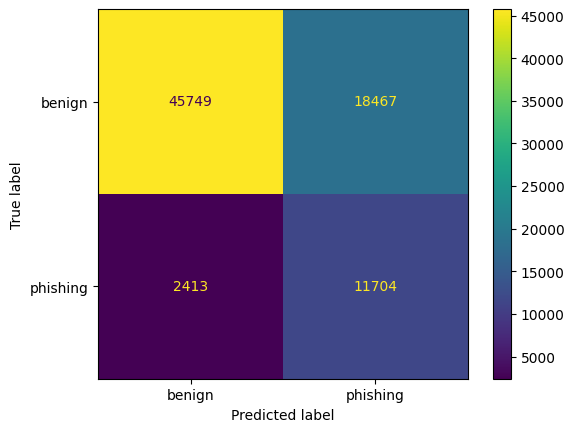

In [27]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["benign", "phishing"])                            
matrix.plot()

In [28]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
F1_score = metrics.f1_score(y_test, y_pred)

In [29]:
print({"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"F1_score":F1_score})

{'Accuracy': 0.7334456742369116, 'Precision': 0.38792217692486164, 'Recall': 0.82907133243607, 'F1_score': 0.5285404624277458}


In [30]:
df = pd.read_csv("../Metrics of Dataset (Undersampling)#3.csv")

In [31]:
metrics = pd.DataFrame({"Model": "TCN", "Accuracy": [Accuracy], "Precision":[Precision], "Recall": [Recall], "F1_score": [F1_score]})

In [33]:
df = pd.concat([df, metrics], ignore_index=True)

In [34]:
df.head()

,Model,Accuracy,Precision,Recall,F1_score
0,LinearSVC,0.623415,0.303641,0.842459,0.446392
1,Random Forest,0.733254,0.390210,0.853227,0.535512
2,XGBoost,0.730803,0.387978,0.854998,0.533752
3,MLP,0.732029,0.389243,0.855635,0.535073
4,TCN,0.733446,0.387922,0.829071,0.528540


In [35]:
df.to_csv("../Metrics of Dataset (Undersampling)#3.csv", index=False)